## Libraries

In [54]:
# importing libraries 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

# extreme gradient boosting library
from xgboost import XGBRegressor

## Preliminary data checking

In [31]:
# reading data
X = pd.read_csv('Data/train.csv', index_col='Id')
X_test_full = pd.read_csv('Data/test.csv', index_col='Id')

In [32]:
X.shape

(1460, 80)

In [33]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Preprocessing data

In [34]:
# clear rows without target parameter 'Price'
X.dropna(axis=0, subset=['SalePrice'], inplace=True)

# set target
y = X.SalePrice

# drop target from features set
X.drop(['SalePrice'], axis=1, inplace=True)

# split data
X_train_full, X_valid_full, y_train_full, y_valid_full = train_test_split(
    X, 
    y, 
    train_size=0.8,
    test_size=0.2,
    random_state=0
)

In [35]:
# select categorical features with low cardinality
low_cardinality_cols = [card_col for card_col in X_train_full.columns if 
                        X_train_full[card_col].nunique() < 10 and
                        X_train_full[card_col].dtype == 'object']
# select numeric features
numeric_cols = [n_col for n_col in X_train_full.columns if 
                X_test_full[n_col].dtype in ['int64', 'float64']]

In [36]:
# imputation function for categorical features
def imputation_cat_features(train_cat, valid_cat, test_cat, strategy='most_frequent'):
    cat_imputer = SimpleImputer(strategy=strategy)
    
    imp_cat_train = pd.DataFrame(cat_imputer.fit_transform(train_cat))
    imp_cat_valid = pd.DataFrame(cat_imputer.transform(valid_cat))
    imp_cat_test = pd.DataFrame(cat_imputer.transform(test_cat))
    
    imp_cat_train.columns = train_cat.columns
    imp_cat_valid.columns = valid_cat.columns
    imp_cat_test.columns = test_cat.columns
    
    return [imp_cat_train, imp_cat_valid, imp_cat_test]

In [37]:
# imputation function for numerical features
def imputation_num_features(train, valid, test, strategy):
    num_imputer = SimpleImputer(strategy=strategy)
    
    imp_train = pd.DataFrame(num_imputer.fit_transform(train))
    imp_valid = pd.DataFrame(num_imputer.transform(valid))
    imp_test = pd.DataFrame(num_imputer.transform(test))
    
    imp_train.columns = train.columns
    imp_valid.columns = valid.columns
    imp_test.columns = test.columns
    
    return [imp_train, imp_valid, imp_test]

In [38]:
# defining categorical features for train, valid and test data subsets
X_train_cat = X_train_full[low_cardinality_cols]
X_valid_cat = X_valid_full[low_cardinality_cols]
X_test_cat = X_test_full[low_cardinality_cols]

# imputation categorical features
imp_X_train_cat, imp_X_valid_cat, imp_X_test_cat = imputation_cat_features(
    X_train_cat, X_valid_cat, X_test_cat
)

In [39]:
print(imp_X_train_cat.shape, imp_X_valid_cat.shape, imp_X_test_cat.shape)

(1168, 40) (292, 40) (1459, 40)


In [40]:
# defining numerical features for train, valid and test data subsets
X_train_num = X_train_full[numeric_cols]
X_valid_num = X_valid_full[numeric_cols]
X_test_num = X_test_full[numeric_cols]

# imputation numerical features
imp_X_train_num, imp_X_valid_num, imp_X_test_num = imputation_num_features(
    X_train_num, X_valid_num, X_test_num, 'mean'
)

In [41]:
# concatenation of numerical and categorical features
X_train = pd.concat([imp_X_train_num, imp_X_train_cat], axis=1)
X_valid = pd.concat([imp_X_valid_num, imp_X_valid_cat], axis=1)
X_test = pd.concat([imp_X_test_num, imp_X_test_cat], axis=1)

In [42]:
# one-hot encoder (for categorical data) on full data set
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)

In [43]:
# checking data before alignment
print(f"X_train: {X_train.shape}\nX_valid: {X_valid.shape}\nX_test: {X_test.shape}")

X_train: (1168, 227)
X_valid: (292, 208)
X_test: (1459, 217)


In [44]:
# align datasets for the same number of columns
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [45]:
# checking data after alignment
print(f"X_train: {X_train.shape}\nX_valid: {X_valid.shape}\nX_test: {X_test.shape}")

X_train: (1168, 227)
X_valid: (292, 227)
X_test: (1459, 227)


## XGBoost

In [48]:
def score_xgb_model(n, alpha, stop_rounds, verb=False):
    # defining XGBoost model
    xgb_model = XGBRegressor(n_estimators=n, learning_rate=alpha)

    # fitting model
    xgb_model.fit(
        X_train,
        y_train_full,
        early_stopping_rounds=stop_rounds,
        eval_set=[(X_valid, y_valid_full)],
        verbose=verb
    )
    
    # getting predictions
    preds = xgb_model.predict(X_valid)
    
    # evaluating model efficiency
    mae = mean_absolute_error(preds, y_valid_full)
    
    return mae

In [110]:
# defining ten models with different alpha rate parameter
model_1 = score_xgb_model(1000, 0.01, 20)
model_2 = score_xgb_model(1000, 0.02, 20)
model_3 = score_xgb_model(1000, 0.03, 20)
model_4 = score_xgb_model(1000, 0.04, 20)
model_5 = score_xgb_model(1000, 0.05, 20)
model_6 = score_xgb_model(1000, 0.06, 20)
model_7 = score_xgb_model(1000, 0.07, 20)
model_8 = score_xgb_model(1000, 0.08, 20)
model_9 = score_xgb_model(1000, 0.09, 20)
model_10 = score_xgb_model(1000, 0.1, 20)

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10]

results = pd.Series(models, index=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

## Testing - data visualization

Text(0, 0.5, 'Score')

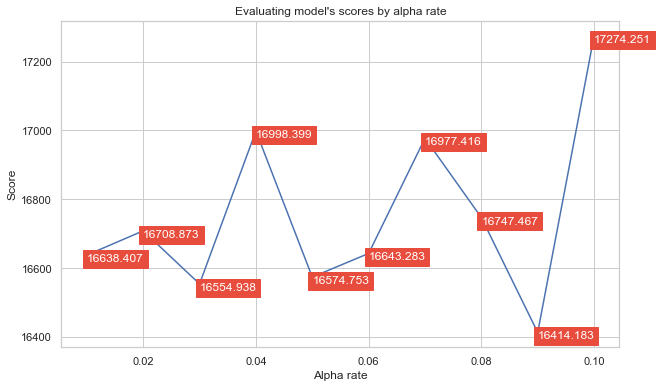

In [115]:
# visualizing results

# plot area size
plt.figure(figsize=(10,6))

# style
sns.set_theme(style="whitegrid")

# plot title
plt.title("Evaluating model's scores by alpha rate")

# define barplot
lineplot = sns.lineplot(data=results)


# label points on the plot
for x, y in zip(results.index, results.values):
 # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
 plt.text(x = x, # x-coordinate position of data label
 y = y-20, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = "{:.3f}".format(y), # data label, formatted to ignore decimals
 color = '#ffffff').set_backgroundcolor('#e74c3c') # set colour of line


# axis labels
plt.xlabel("Alpha rate")
plt.ylabel("Score")